In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt

import igraph
import operator
import numpy as np
import math
from IPython.display import *
from os import path
from wordcloud import WordCloud
import re
from utils import *
import pandas as pd
from collections import Counter
import glob

def displayNetwork(g, visual_style={}):
    igraph.plot(g, "temp.png", **visual_style)
    display(Image(filename='temp.png'))

In [2]:
main_dir = './scored_tweets/'
files = glob.glob('%s/scored_*.df'%main_dir)
### If you want just one chunk
scored_dataframe = pd.read_pickle(files[0])
### If you wan to concat everything (takes some time)

#scored_dataframe = pd.read_pickle(files[0])
#for f in glob.glob('%s/scored_*.df'%main_dir)[1:]:
    #print(f)
    #scored_dataframe = pd.concat([scored_dataframe,  pd.read_pickle(f)])
    #print('Done')

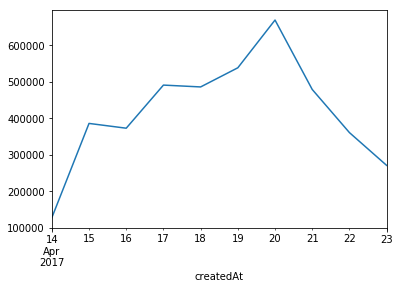

In [6]:
scored_dataframe['2017-04-14':].resample('1D').count()['id'].plot()

In [12]:
scored_dataframe_wc = scored_dataframe.filter(['candidate_ref', 'id', 'score_neg', 'score_pos', 'relevant_words'])
scored_dataframe_wc['score'] = scored_dataframe_wc['score_neg']+scored_dataframe_wc['score_pos']
scored_dataframe_wc = scored_dataframe_wc[(scored_dataframe_wc['score'] > 4 )| (scored_dataframe_wc['score'] < 0)]

In [13]:
scored_dataframe_wc['polarity'] = np.sign(scored_dataframe_wc['score'])

In [14]:
def count_words(group):
    return Counter([item.lower() for sublist in group['relevant_words'].tolist() for item in sublist])

In [15]:
words_counted = scored_dataframe_wc.groupby('candidate_ref').apply(lambda group: group.groupby('polarity').apply(count_words))

In [21]:
w_to_remove = {}
w_to_remove['Hamon'] = ['benoit','hamon', 'benoît', 'hamon2017', 'presidentielle2017']
w_to_remove['Lepen'] = ['marine', 'marine2017', 'presidentielle2017', 'madame', 'lepen', 'hey',\
                       '2017ledebat', '2017ledébat', 'france', 'francais', 'français', 'mlp', 'debat2017', 'débat',\
                       'candidat', 'tour', 'soir', 'fn', 'news', 'marinelepen']
w_to_remove['Macron'] = ['macron', 'macronpresident', 'emmanuel', 'marche', 'enmarche', 'macron2017', 'presidentielle2017',\
                         'france', 'francais', 'français', 'monsieur', '2017ledebat', 'debat2017']
w_to_remove['Melenchon'] = ['jlm2017','mélenchon', 'melenchon', 'jean-luc', 'presidentielle2017']
w_to_remove['Dupont'] = ['nicolas', 'nda2017', 'dupontaignan', 'presidentielle2017']
w_to_remove['Cheminade'] = ['jacques', 'cheminade2017', 'cheminade', 'presidentielle2017']
w_to_remove['Arthaud'] = ['nathalie', 'presidentielle2017']
w_to_remove['Poutou'] = ['poutou', 'presidentielle2017']
w_to_remove['Fillon'] = ['fillon2017','fillon', 'françois', 'fillonprésident', 'fillonpresident', 'presidentielle2017']
w_to_remove['Lassalle'] = ['lassalle2017', 'presidentielle2017']
w_to_remove['Asselineau'] = ['françois', 'asselineau', 'asselineau2017', 'presidentielle2017', 'upr']

def clean_useless_words(row, w_to_remove):
    for w in w_to_remove[row.name]:
        if w in row.loc[1]:
            row.loc[1].pop(w)
        if w in row.loc[-1]:
            row.loc[-1].pop(w)
def keep_important_words(counter, pct):
    ##list of keys sorted by values
    keys = sorted(counter, key=counter.get, reverse=True)
    ##max number of keys to respect the percentage
    max_index = math.ceil(pct*len(keys))
    ##returns a dictionnary of key,values according to the list of important keys
    return {k:counter[k] for k in keys[:max_index] if k !=''}

In [76]:
_ = words_counted.apply(lambda row: clean_useless_words(row, w_to_remove), axis=1)
percentage = 0.01
important_words = words_counted.applymap(lambda x: keep_important_words(x,percentage))

## Wordclouds

In [87]:
def infographic(table, candidate, polarity):
    if polarity == 1:
        cmap = 'summer'
    else:
        cmap='Reds'
    wordcloud = WordCloud(colormap=cmap, background_color='white').generate_from_frequencies(table.loc[candidate, polarity])
    wordcloud.background_color='white'
    plt.figure(figsize=(20,40))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    return wordcloud


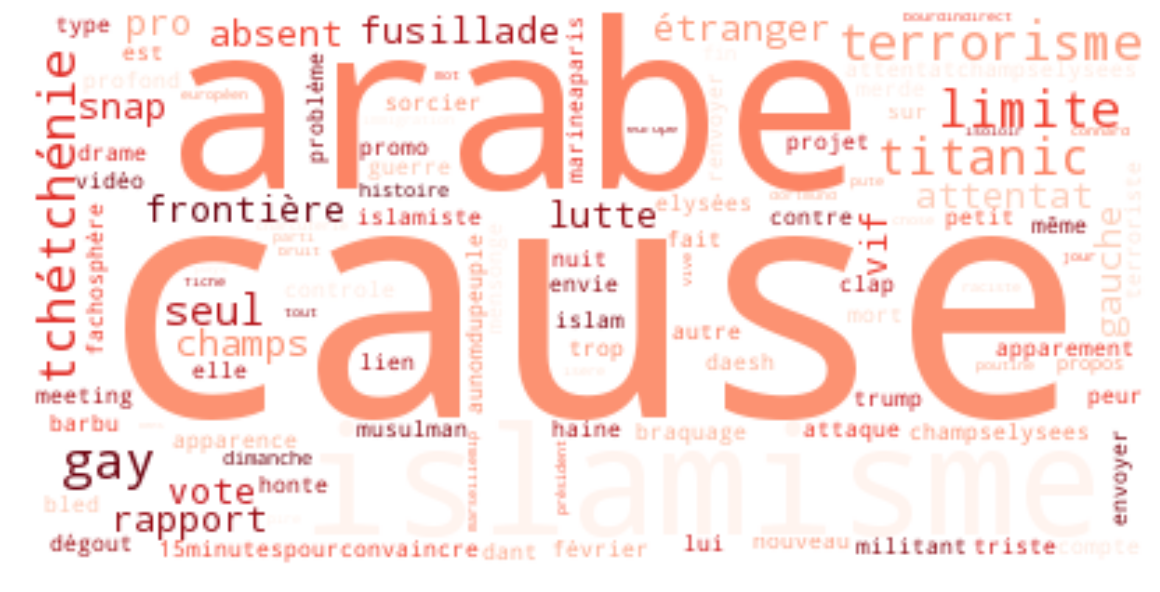

In [88]:
wc = infographic(important_words, 'Lepen', -1)

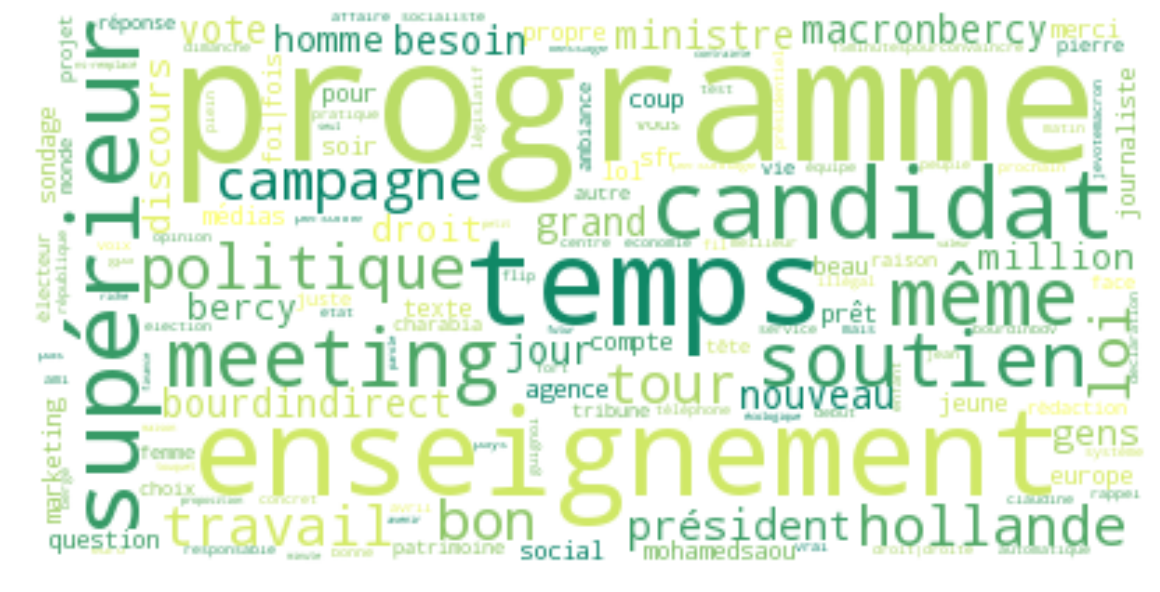

In [89]:
wc2 = infographic(important_words, 'Macron', 1)

## Networks

In [104]:
g=igraph.Graph() # this is an initialization of our graph outside the function
g.es["weight"] = 1.0 

def network(g, Table, cand, pol, imp): 
    table = Table[(Table['candidate_ref'] == cand ) & (Table['polarity'] == pol)]
    g.add_vertices(1)
    g.vs["name"]=cand # the first node just contains the name of the candidate 
    g.vs["index"] = 0
    g.vs["label"] = g.vs["name"]
    
    
    for words in table['relevant_words']:
        temp=[]
        if np.random.rand(1)<=(1/5): # SAMPLING to reduce time for illustration reasons
            for w in words:
                if w in imp.loc[cand,pol] and w !='': 
                    temp.append(w)
                    h=igraph.Graph()
                    h.add_vertices(1)
                    h.vs["name"]=w       

                    if h.vs["name"][0] not in g.vs["name"]:    
                        g.add_vertices(1)
                        g.vs(len(g.vs)-1)["name"]=h.vs["name"]
                        g.vs(len(g.vs)-1)["label"] = g.vs(len(g.vs)-1)["name"]
                        g.vs(len(g.vs)-1)["index"]=len(g.vs)-1                       


                        for t in temp:                    
                            g.add_edge(g.vs.select(name=w)["index"][0], g.vs.select(name=t)["index"][0])
                            g[w,t]=1                    
                    else:
                        for t in temp:
                            if not g.are_connected(int(str(g.vs.select(name=w)["index"])[1:-1]), int(str(g.vs.select(name=t)["index"])[1:-1])):
                                g.add_edge(int(str(g.vs.select(name=w)["index"])[1:-1]), int(str(g.vs.select(name=t)["index"])[1:-1]))
                                g[w,t]=1
                            else:
                                g[w,t]=g[w,t]+1
    
    
    g=g.simplify(loops=True, multiple=False)    
    g.delete_vertices(0)
    print(g.vs["label"])
    return g



dok_g = network(g, scored_dataframe_wc, 'Macron', -1, important_words)
print('Done')

['trahison', 'autre', 'pire', 'impôt', 'mort', 'imposture', 'seul', 'faute', 'grave', 'gauche', 'propos', 'honte', 'petit', 'programme', 'patron', 'dan', 'truc', 'vide', 'con', 'sujet', 'campagne', 'chômage', 'dernier', 'fin', 'vidéo', 'peur', 'hollande', 'rien', 'militant', 'coup', 'meeting', 'porte-parole', 'présidentiel', 'mensonge', 'politique', 'islamiste', 'radical', 'chômeur', 'même', 'mec', 'candidat', 'ns-remplacé', 'ennemi', 'taxe', 'histoire', 'chose', 'est', 'adversaire', 'ambiguïté', 'contradiction', 'éco', 'beurfm', 'type', 'problème', 'critique', 'faux', 'délit', 'communautarisme', 'preuve', 'accablant', 'oligarchie', 'gênant', 'terroriste', 'emmanuelhollande', 'fait', 'scandale', 'bien', 'islamique', 'terrorisme', 'attentat', 'projet', 'pas', 'cas', 'nuit', 'flou', 'risque', 'menace', 'lutte', 'milliard', 'participant', 'mohamedsaou', 'communiste', 'charge', 'mohamed', 'censure', 'guerre', 'fond', 'presse', 'intervention', 'stopmacron', 'piège', 'saou', 'résumé', 'chef'

In [105]:
### Visual style 1

visual_style = {}
visual_style["layout"] = dok_g.layout_fruchterman_reingold(weights=[math.pow(i,1/10) for i in dok_g.es["weight"]])
visual_style["margin"] = 20
visual_style["edge_curved"] = 0.2
visual_style["edge_width"] = 0.2
visual_style["edge_arrow_size"] = 0.2
visual_style["edge_arrow_width"] = 1
visual_style["vertex_color"] = "white"
visual_style["bbox"] = (1200, 1200)
visual_style["vertex_label_color"]= "blue"
visual_style["edge_color"]="orange"
visual_style["vertex_size"] = 2
visual_style["vertex_shape"] = "circle"
visual_style['vertex_label_size'] = 20

In [106]:
print("number of nodes: ", dok_g.vcount())
print("number of edges: ", dok_g.ecount())
print("sum of weights: ", sum((dok_g.es["weight"])))

number of nodes:  119
number of edges:  1222
sum of weights:  26588


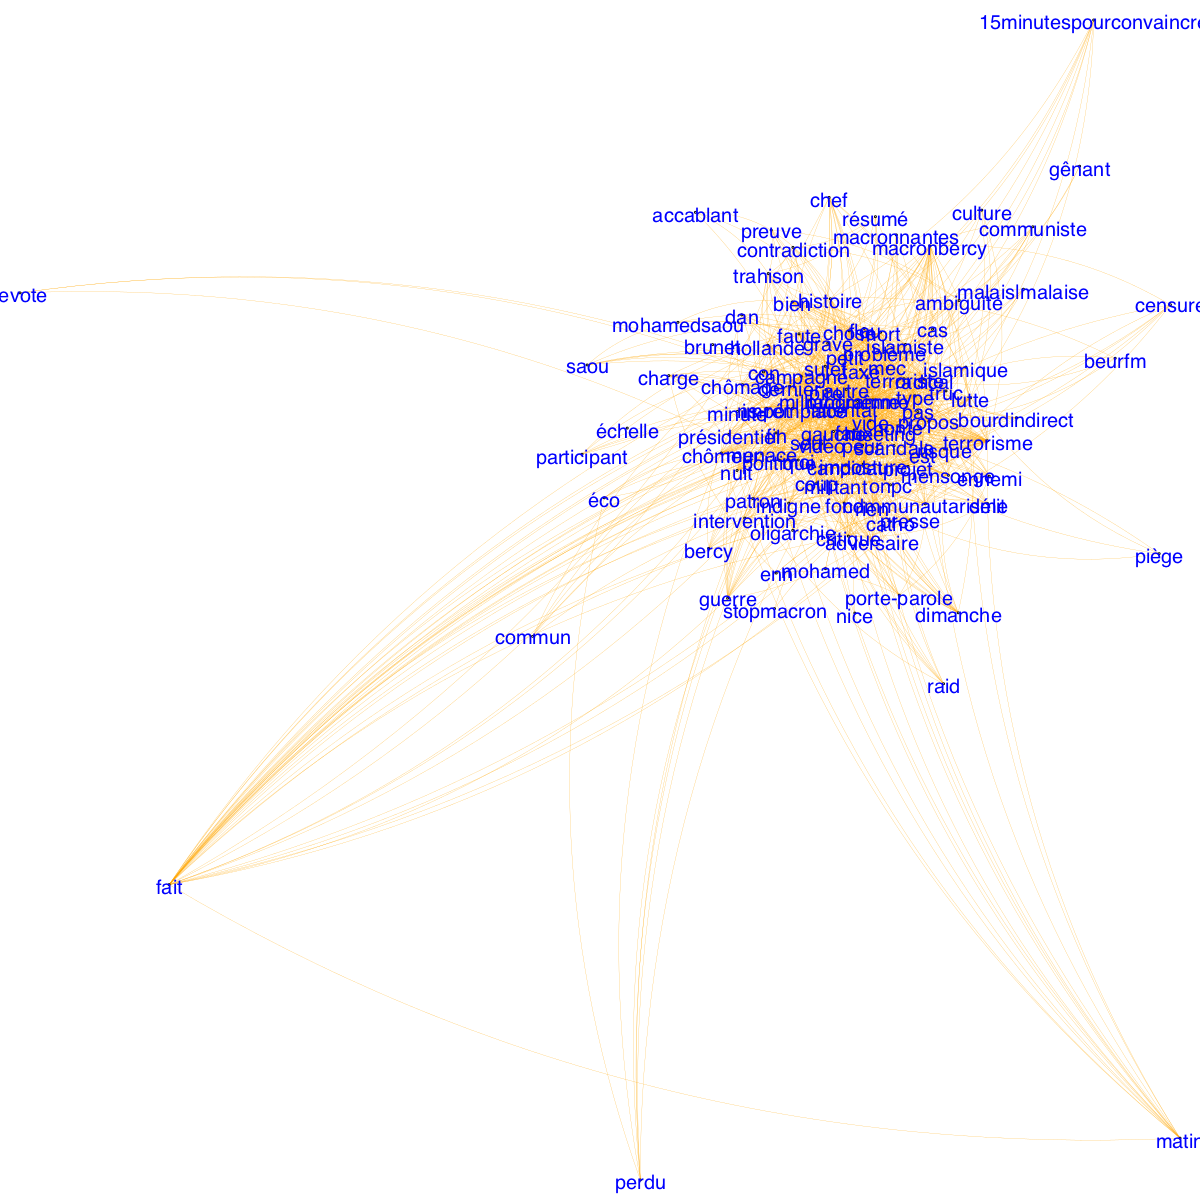

In [107]:
displayNetwork(dok_g.clusters().giant(), visual_style)

In [108]:
ed_tabl=[]
for e in dok_g.es():
    ed_tabl.append([e["weight"], dok_g.vs(e.source)["name"], dok_g.vs(e.target)["name"]])

ed_tabl=pd.DataFrame(ed_tabl)
ed_tabl.columns=["Edge Weight", "Node 1", "Node 2"]

In [109]:
ed_tabl.sort_values(by="Edge Weight", ascending=False).iloc[:20]

,Edge Weight,Node 1,Node 2
32,727,[radical],[type]
147,678,[terrorisme],[lutte]
946,667,[programme],[terrorisme]
623,619,[porte-parole],[communautarisme]
945,534,[programme],[lutte]
809,441,[petit],[résumé]
1116,440,[petit],[contradiction]
1117,440,[contradiction],[résumé]
947,406,[programme],[nuit]
949,398,[terrorisme],[nuit]
